In [ ]:
import pandas as pd
import numpy as np

def preprocess_taipower_year(csv_path: str) -> pd.DataFrame:

    df_raw = pd.read_csv(csv_path)

    # -------------------------------
    # 1) wide → long，把 00–23 攤平成一欄
    # -------------------------------
    hour_cols = [c for c in df_raw.columns if c.isdigit() and len(c) == 2]

    df_long = df_raw.melt(
        id_vars=["測站", "日期", "測項"],
        value_vars=hour_cols,
        var_name="hour_str",
        value_name="value",
    )

    # -------------------------------
    # 2) 建立 datetime
    # -------------------------------
    df_long["date"] = pd.to_datetime(df_long["日期"]).dt.floor("D")
    df_long["hour"] = df_long["hour_str"].astype(int)
    df_long["datetime"] = df_long["date"] + pd.to_timedelta(df_long["hour"], unit="h")

    # -------------------------------
    # 3) pivot：每個 datetime 一列
    # -------------------------------
    df_pivot = df_long.pivot_table(
        index="datetime",
        columns="測項",
        values="value",
        aggfunc="first",
    ).sort_index()

    # ============================================================
    # ===  Step: 補齊缺失的小時（完整時間序列 reindex） 
    # ============================================================
    full_range = pd.date_range(
        start=df_pivot.index.min(),
        end=df_pivot.index.max(),
        freq="H"
    )

    df_pivot = df_pivot.reindex(full_range)

    # -------------------------------
    # 4) 組成跟 all_data 一樣的欄位
    # -------------------------------
    out = pd.DataFrame(index=df_pivot.index)

    out["PM25"]       = pd.to_numeric(df_pivot.get("PM2.5"),      errors="coerce")
    out["TEMP"]       = pd.to_numeric(df_pivot.get("AMB_TEMP"),   errors="coerce")
    out["RH"]         = pd.to_numeric(df_pivot.get("RH"),         errors="coerce")
    out["wind_speed"] = pd.to_numeric(df_pivot.get("WIND_SPEED"), errors="coerce")
    out["wind_direc"] = pd.to_numeric(df_pivot.get("WIND_DIREC"), errors="coerce")
    out["rainfall"]   = pd.to_numeric(df_pivot.get("RAINFALL"),   errors="coerce")

    # 風向
    out["WD"] = out["wind_direc"]
    rad = np.deg2rad(out["WD"].astype(float))
    out["WD_sin"] = np.sin(rad)
    out["WD_cos"] = np.cos(rad)

    # 時間特徵
    out["hour"]    = out.index.hour
    out["weekday"] = out.index.weekday
    out["month"]   = out.index.month

    # season mapping
    month = out["month"]
    season = pd.Series(index=out.index, dtype="Int64")
    season[(month == 12) | (month <= 2)] = 1
    season[(month >= 3) & (month <= 5)] = 2
    season[(month >= 6) & (month <= 8)] = 3
    season[(month >= 9) & (month <= 11)] = 4
    out["season"] = season

    # index → column
    out = out.reset_index().rename(columns={"index": "datetime"})

    # 整理欄位順序
    out = out[[
        "datetime",
        "PM25", "TEMP", "RH",
        "wind_speed", "wind_direc", "rainfall",
        "WD", "WD_sin", "WD_cos",
        "hour", "weekday", "month", "season",
    ]]

    return out


In [63]:
df_2021 = preprocess_taipower_year("中壢_2021.csv")
df_2021

C:\Users\88692\AppData\Local\Temp\ipykernel_34772\3148946685.py:40: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(


,datetime,PM25,TEMP,RH,wind_speed,wind_direc,rainfall,WD,WD_sin,WD_cos,hour,weekday,month,season
0,2021-01-01 00:00:00,25.0,10.3,71.0,0.4,334.0,0.0,334.0,-0.438371,0.898794,0,4,1,1
1,2021-01-01 01:00:00,24.0,10.5,70.0,0.5,349.0,0.0,349.0,-0.190809,0.981627,1,4,1,1
2,2021-01-01 02:00:00,20.0,10.4,70.0,0.4,355.0,0.0,355.0,-0.087156,0.996195,2,4,1,1
3,2021-01-01 03:00:00,19.0,10.4,70.0,0.5,23.0,0.0,23.0,0.390731,0.920505,3,4,1,1
4,2021-01-01 04:00:00,13.0,10.6,70.0,0.5,25.0,0.0,25.0,0.422618,0.906308,4,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2021-12-31 19:00:00,10.0,15.3,85.0,1.4,349.0,0.0,349.0,-0.190809,0.981627,19,4,12,1
8756,2021-12-31 20:00:00,7.0,15.3,89.0,1.5,319.0,0.0,319.0,-0.656059,0.754710,20,4,12,1
8757,2021-12-31 21:00:00,7.0,15.4,92.0,1.4,341.0,0.0,341.0,-0.325568,0.945519,21,4,12,1
8758,2021-12-31 22:00:00,11.0,15.4,93.0,1.2,273.0,0.0,273.0,-0.998630,0.052336,22,4,12,1


In [78]:
# 讀 2022 年的原始檔
df_2022 = preprocess_taipower_year("中壢_2022.csv")
df_2022

C:\Users\88692\AppData\Local\Temp\ipykernel_34772\3148946685.py:40: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(


,datetime,PM25,TEMP,RH,wind_speed,wind_direc,rainfall,WD,WD_sin,WD_cos,hour,weekday,month,season
0,2022-01-01 00:00:00,9.0,15.2,97.0,1.1,313.0,0.0,313.0,-0.731354,0.681998,0,5,1,1
1,2022-01-01 01:00:00,12.0,15.3,97.0,1.1,292.0,0.0,292.0,-0.927184,0.374607,1,5,1,1
2,2022-01-01 02:00:00,8.0,15.2,97.0,1.0,285.0,0.0,285.0,-0.965926,0.258819,2,5,1,1
3,2022-01-01 03:00:00,6.0,15.3,97.0,0.5,315.0,0.0,315.0,-0.707107,0.707107,3,5,1,1
4,2022-01-01 04:00:00,6.0,15.4,96.0,0.4,287.0,0.0,287.0,-0.956305,0.292372,4,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,14.0,16.3,92.0,1.1,287.0,0.0,287.0,-0.956305,0.292372,19,5,12,1
8756,2022-12-31 20:00:00,10.0,16.3,94.0,1.2,294.0,0.0,294.0,-0.913545,0.406737,20,5,12,1
8757,2022-12-31 21:00:00,10.0,16.3,95.0,1.5,16.0,0.0,16.0,0.275637,0.961262,21,5,12,1
8758,2022-12-31 22:00:00,11.0,16.5,94.0,1.5,41.0,0.0,41.0,0.656059,0.754710,22,5,12,1


In [93]:
# 讀 2023 年的原始檔
df_2023 = preprocess_taipower_year("中壢_2023.csv")
df_2023

C:\Users\88692\AppData\Local\Temp\ipykernel_34772\3148946685.py:40: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(


,datetime,PM25,TEMP,RH,wind_speed,wind_direc,rainfall,WD,WD_sin,WD_cos,hour,weekday,month,season
0,2023-01-01 00:00:00,16.0,16.7,93.0,1.4,337.0,0.0,337.0,-0.390731,0.920505,0,6,1,1
1,2023-01-01 01:00:00,7.0,17.0,93.0,1.8,14.0,0.0,14.0,0.241922,0.970296,1,6,1,1
2,2023-01-01 02:00:00,5.0,17.1,94.0,1.6,25.0,0.0,25.0,0.422618,0.906308,2,6,1,1
3,2023-01-01 03:00:00,3.0,17.3,94.0,1.7,320.0,0.0,320.0,-0.642788,0.766044,3,6,1,1
4,2023-01-01 04:00:00,8.0,17.4,95.0,1.7,354.0,0.0,354.0,-0.104528,0.994522,4,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 19:00:00,43.0,17.9,68.0,1.3,331.0,0.0,331.0,-0.484810,0.874620,19,6,12,1
8756,2023-12-31 20:00:00,36.0,17.6,68.0,1.6,325.0,0.0,325.0,-0.573576,0.819152,20,6,12,1
8757,2023-12-31 21:00:00,33.0,17.3,66.0,1.6,325.0,0.0,325.0,-0.573576,0.819152,21,6,12,1
8758,2023-12-31 22:00:00,34.0,17.0,65.0,1.4,312.0,0.0,312.0,-0.743145,0.669131,22,6,12,1


In [94]:
# 讀 2024 年的原始檔
df_2024 = preprocess_taipower_year("中壢_2024.csv")
df_2024

C:\Users\88692\AppData\Local\Temp\ipykernel_34772\3148946685.py:40: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(


,datetime,PM25,TEMP,RH,wind_speed,wind_direc,rainfall,WD,WD_sin,WD_cos,hour,weekday,month,season
0,2024-01-01 00:00:00,44.0,16.4,62.0,2.0,350.0,0.0,350.0,-0.173648,0.984808,0,0,1,1
1,2024-01-01 01:00:00,30.0,16.1,63.0,1.6,325.0,0.0,325.0,-0.573576,0.819152,1,0,1,1
2,2024-01-01 02:00:00,37.0,15.8,64.0,1.4,344.0,0.0,344.0,-0.275637,0.961262,2,0,1,1
3,2024-01-01 03:00:00,29.0,15.7,66.0,1.6,20.0,0.0,20.0,0.342020,0.939693,3,0,1,1
4,2024-01-01 04:00:00,32.0,15.6,67.0,1.3,27.0,0.0,27.0,0.453990,0.891007,4,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2024-12-31 19:00:00,37.0,15.4,55.0,1.1,329.0,0.0,329.0,-0.515038,0.857167,19,1,12,1
8780,2024-12-31 20:00:00,42.0,15.1,56.0,1.0,312.0,0.0,312.0,-0.743145,0.669131,20,1,12,1
8781,2024-12-31 21:00:00,46.0,15.0,59.0,1.5,18.0,0.0,18.0,0.309017,0.951057,21,1,12,1
8782,2024-12-31 22:00:00,50.0,14.8,62.0,1.5,39.0,0.0,39.0,0.629320,0.777146,22,1,12,1


# 檢查缺資料

In [107]:
# 讀資料
df = df_2024

In [108]:
# 排序
df = df.sort_values("datetime").reset_index(drop=True)

print("=== 基本資訊 ===")
print("資料筆數：", len(df))
print("時間範圍：", df['datetime'].min(), " ~ ", df['datetime'].max())

# ============================================================
# 1. 檢查是否有重複的時間
# ============================================================
dups = df[df.duplicated("datetime")]
print("\n=== 重複的 timestamp 數量 ===")
print(len(dups))
if not dups.empty:
    print(dups.head())

# ============================================================
# 2. 建立完整的 2024 年每小時時間序列
# ============================================================
full_range = pd.date_range("2024-01-01 00:00", "2024-12-31 23:00", freq="H")

# 找缺失時間
missing = full_range.difference(df["datetime"])

print("\n=== 缺失的小時數 ===")
print(len(missing))
if len(missing) > 0:
    print("前幾個缺失的時間：")
    print(missing[:10])

# ============================================================
# 3. 檢查是否有「超出範圍」的時間（可能表示錯誤日期）
# ============================================================
out_of_range = df[
    (df["datetime"] < full_range[0]) |
    (df["datetime"] > full_range[-1])
]

print("\n=== 超出 2024 範圍的時間筆數 ===")
print(len(out_of_range))
if not out_of_range.empty:
    print(out_of_range.head())

# ============================================================
# 4. 檢查是否每筆都是整點（避免奇怪的 timestamp）
# ============================================================
weird_minutes = df[df["datetime"].dt.minute != 0]

print("\n=== 非整點的時間筆數（不應該發生） ===")
print(len(weird_minutes))
if not weird_minutes.empty:
    print(weird_minutes.head())


=== 基本資訊 ===
資料筆數： 8784
時間範圍： 2024-01-01 00:00:00  ~  2024-12-31 23:00:00

=== 重複的 timestamp 數量 ===
0

=== 缺失的小時數 ===
0

=== 超出 2024 範圍的時間筆數 ===
0

=== 非整點的時間筆數（不應該發生） ===
0


C:\Users\88692\AppData\Local\Temp\ipykernel_34772\2012857484.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range("2024-01-01 00:00", "2024-12-31 23:00", freq="H")


In [109]:
missing_report = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_percent": df.isna().mean() * 100
})

print(missing_report)


            missing_count  missing_percent
datetime                0         0.000000
PM25                  124         1.411658
TEMP                   17         0.193534
RH                     23         0.261840
wind_speed             17         0.193534
wind_direc             17         0.193534
rainfall               53         0.603370
WD                     17         0.193534
WD_sin                 17         0.193534
WD_cos                 17         0.193534
hour                    0         0.000000
weekday                 0         0.000000
month                   0         0.000000
season                  0         0.000000


# 補資料

In [110]:
df_2024

,datetime,PM25,TEMP,RH,wind_speed,wind_direc,rainfall,WD,WD_sin,WD_cos,hour,weekday,month,season
0,2024-01-01 00:00:00,44.0,16.4,62.0,2.0,350.0,0.0,350.0,-0.173648,0.984808,0,0,1,1
1,2024-01-01 01:00:00,30.0,16.1,63.0,1.6,325.0,0.0,325.0,-0.573576,0.819152,1,0,1,1
2,2024-01-01 02:00:00,37.0,15.8,64.0,1.4,344.0,0.0,344.0,-0.275637,0.961262,2,0,1,1
3,2024-01-01 03:00:00,29.0,15.7,66.0,1.6,20.0,0.0,20.0,0.342020,0.939693,3,0,1,1
4,2024-01-01 04:00:00,32.0,15.6,67.0,1.3,27.0,0.0,27.0,0.453990,0.891007,4,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2024-12-31 19:00:00,37.0,15.4,55.0,1.1,329.0,0.0,329.0,-0.515038,0.857167,19,1,12,1
8780,2024-12-31 20:00:00,42.0,15.1,56.0,1.0,312.0,0.0,312.0,-0.743145,0.669131,20,1,12,1
8781,2024-12-31 21:00:00,46.0,15.0,59.0,1.5,18.0,0.0,18.0,0.309017,0.951057,21,1,12,1
8782,2024-12-31 22:00:00,50.0,14.8,62.0,1.5,39.0,0.0,39.0,0.629320,0.777146,22,1,12,1


In [111]:
df = df_2024.copy()

# 1) 把 datetime 設定成 index
df = df.set_index("datetime")

# 2) 建立完整時間序列（小時頻率）
full_index = pd.date_range(
    start=df.index.min(),
    end=df.index.max(),
    freq="H"
)

# 3) reindex → 自動補出缺的小時（整列 NaN）
df = df.reindex(full_index)

# 4) 把 index 重新當成欄位
df.index.name = "datetime"
df = df.reset_index()

# ========================
# 下面接你原本的補值方法
# ========================

# 5) 補一般數值欄位
cols_normal = ["PM25", "TEMP", "RH", "wind_speed", "rainfall"]
for col in cols_normal:
    df[col] = df[col].interpolate(method="linear", limit_direction="both")

# 6) 補風向（用 sin / cos）
rad = np.deg2rad(df["wind_direc"])
df["WD_sin"] = np.sin(rad)
df["WD_cos"] = np.cos(rad)

df["WD_sin"] = df["WD_sin"].interpolate(method="linear", limit_direction="both")
df["WD_cos"] = df["WD_cos"].interpolate(method="linear", limit_direction="both")

df["wind_direc"] = np.rad2deg(np.arctan2(df["WD_sin"], df["WD_cos"])) % 360
df["WD"] = df["wind_direc"]

# 7) 重新計算 WD_sin / WD_cos（確保一致）
df["WD_sin"] = np.sin(np.deg2rad(df["wind_direc"]))
df["WD_cos"] = np.cos(np.deg2rad(df["wind_direc"]))


C:\Users\88692\AppData\Local\Temp\ipykernel_34772\3043680726.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(


## 檢查一下

In [112]:
missing_report = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_percent": df.isna().mean() * 100
})

print(missing_report)


            missing_count  missing_percent
datetime                0              0.0
PM25                    0              0.0
TEMP                    0              0.0
RH                      0              0.0
wind_speed              0              0.0
wind_direc              0              0.0
rainfall                0              0.0
WD                      0              0.0
WD_sin                  0              0.0
WD_cos                  0              0.0
hour                    0              0.0
weekday                 0              0.0
month                   0              0.0
season                  0              0.0


In [113]:
df.loc[(df["PM25"] < 0) | (df["PM25"] > 500), "PM25"] 

Series([], Name: PM25, dtype: float64)

In [114]:
df.loc[(df["RH"] < 0) | (df["RH"] > 100), "RH"]

Series([], Name: RH, dtype: float64)

In [115]:
df.loc[(df["TEMP"] < -20) | (df["TEMP"] > 45), "TEMP"]

Series([], Name: TEMP, dtype: float64)

In [116]:
df.loc[df["wind_speed"]<0, "wind_speed"]

Series([], Name: wind_speed, dtype: float64)

In [117]:
df.loc[(df["wind_direc"]< 0) | (df["wind_direc"]>360),"wind_direc"]

Series([], Name: wind_direc, dtype: float64)

## 存檔

In [118]:
df.to_csv("all_data_2024.csv", index=False, encoding="utf-8-sig")

# 合併2021~2024

In [3]:
df21 = pd.read_csv("all_data_2021.csv")
df22 = pd.read_csv("all_data_2022.csv")
df23 = pd.read_csv("all_data_2023.csv")
df24 = pd.read_csv("all_data_2024.csv")

df_all = pd.concat([df21, df22, df23, df24], ignore_index=True)
df_all = df_all.sort_values("datetime")

In [4]:
df_all

,datetime,PM25,TEMP,RH,wind_speed,wind_direc,rainfall,WD,WD_sin,WD_cos,hour,weekday,month,season
0,2021-01-01 00:00:00,25.0,10.3,71.0,0.4,334.0,0.0,334.0,-0.438371,0.898794,0,4,1,1
1,2021-01-01 01:00:00,24.0,10.5,70.0,0.5,349.0,0.0,349.0,-0.190809,0.981627,1,4,1,1
2,2021-01-01 02:00:00,20.0,10.4,70.0,0.4,355.0,0.0,355.0,-0.087156,0.996195,2,4,1,1
3,2021-01-01 03:00:00,19.0,10.4,70.0,0.5,23.0,0.0,23.0,0.390731,0.920505,3,4,1,1
4,2021-01-01 04:00:00,13.0,10.6,70.0,0.5,25.0,0.0,25.0,0.422618,0.906308,4,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2024-12-31 19:00:00,37.0,15.4,55.0,1.1,329.0,0.0,329.0,-0.515038,0.857167,19,1,12,1
35060,2024-12-31 20:00:00,42.0,15.1,56.0,1.0,312.0,0.0,312.0,-0.743145,0.669131,20,1,12,1
35061,2024-12-31 21:00:00,46.0,15.0,59.0,1.5,18.0,0.0,18.0,0.309017,0.951057,21,1,12,1
35062,2024-12-31 22:00:00,50.0,14.8,62.0,1.5,39.0,0.0,39.0,0.629320,0.777146,22,1,12,1


# 滯後特徵

In [121]:
# -----------------------
# Step 1: 產生 lag 特徵
# -----------------------
lag_hours = [1, 3, 6, 12, 24]

for h in lag_hours:
    df_all[f"PM25_lag{h}"] = df_all["PM25"].shift(h)
    df_all[f"TEMP_lag{h}"] = df_all["TEMP"].shift(h)
    df_all[f"RH_lag{h}"]   = df_all["RH"].shift(h)
    df_all[f"WD_sin_lag{h}"]   = df_all["WD_sin"].shift(h)
    df_all[f"WD_cos_lag{h}"]   = df_all["WD_cos"].shift(h)
    df_all[f"wind_speed_lag{h}"]   = df_all["wind_speed"].shift(h)


In [122]:
df_all

,datetime,PM25,TEMP,RH,wind_speed,wind_direc,rainfall,WD,WD_sin,WD_cos,...,RH_lag12,WD_sin_lag12,WD_cos_lag12,wind_speed_lag12,PM25_lag24,TEMP_lag24,RH_lag24,WD_sin_lag24,WD_cos_lag24,wind_speed_lag24
0,2021-01-01 00:00:00,25.0,10.3,71.0,0.4,334.0,0.0,334.0,-0.438371,0.898794,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 01:00:00,24.0,10.5,70.0,0.5,349.0,0.0,349.0,-0.190809,0.981627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 02:00:00,20.0,10.4,70.0,0.4,355.0,0.0,355.0,-0.087156,0.996195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 03:00:00,19.0,10.4,70.0,0.5,23.0,0.0,23.0,0.390731,0.920505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 04:00:00,13.0,10.6,70.0,0.5,25.0,0.0,25.0,0.422618,0.906308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2024-12-31 19:00:00,37.0,15.4,55.0,1.1,329.0,0.0,329.0,-0.515038,0.857167,...,83.0,-0.951057,0.309017,0.3,34.0,16.9,84.0,-0.642788,-0.766044,0.5
35060,2024-12-31 20:00:00,42.0,15.1,56.0,1.0,312.0,0.0,312.0,-0.743145,0.669131,...,82.0,-0.707107,0.707107,0.3,40.0,17.0,84.0,-0.515038,-0.857167,0.3
35061,2024-12-31 21:00:00,46.0,15.0,59.0,1.5,18.0,0.0,18.0,0.309017,0.951057,...,74.0,0.156434,0.987688,0.8,40.0,17.1,84.0,-0.978148,0.207912,0.2
35062,2024-12-31 22:00:00,50.0,14.8,62.0,1.5,39.0,0.0,39.0,0.629320,0.777146,...,66.0,0.156434,0.987688,0.9,32.0,17.0,85.0,-0.994522,0.104528,0.2


In [123]:
df_all = df_all.dropna().reset_index(drop=True)

In [124]:
df_all

,datetime,PM25,TEMP,RH,wind_speed,wind_direc,rainfall,WD,WD_sin,WD_cos,...,RH_lag12,WD_sin_lag12,WD_cos_lag12,wind_speed_lag12,PM25_lag24,TEMP_lag24,RH_lag24,WD_sin_lag24,WD_cos_lag24,wind_speed_lag24
0,2021-01-02 00:00:00,15.0,13.4,76.0,0.4,323.0,0.0,323.0,-0.601815,0.798636,...,58.0,0.453990,0.891007,1.5,25.0,10.3,71.0,-0.438371,0.898794,0.4
1,2021-01-02 01:00:00,17.0,13.3,77.0,0.9,24.0,0.0,24.0,0.406737,0.913545,...,56.0,-0.052336,0.998630,1.6,24.0,10.5,70.0,-0.190809,0.981627,0.5
2,2021-01-02 02:00:00,19.0,13.6,79.0,0.7,2.0,0.0,2.0,0.034899,0.999391,...,57.0,-0.484810,0.874620,1.0,20.0,10.4,70.0,-0.087156,0.996195,0.4
3,2021-01-02 03:00:00,13.0,13.7,79.0,0.9,14.0,0.0,14.0,0.241922,0.970296,...,60.0,0.069756,0.997564,1.3,19.0,10.4,70.0,0.390731,0.920505,0.5
4,2021-01-02 04:00:00,20.0,13.2,78.0,0.8,19.0,0.0,19.0,0.325568,0.945519,...,64.0,0.358368,0.933580,1.2,13.0,10.6,70.0,0.422618,0.906308,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2024-12-31 19:00:00,37.0,15.4,55.0,1.1,329.0,0.0,329.0,-0.515038,0.857167,...,83.0,-0.951057,0.309017,0.3,34.0,16.9,84.0,-0.642788,-0.766044,0.5
35036,2024-12-31 20:00:00,42.0,15.1,56.0,1.0,312.0,0.0,312.0,-0.743145,0.669131,...,82.0,-0.707107,0.707107,0.3,40.0,17.0,84.0,-0.515038,-0.857167,0.3
35037,2024-12-31 21:00:00,46.0,15.0,59.0,1.5,18.0,0.0,18.0,0.309017,0.951057,...,74.0,0.156434,0.987688,0.8,40.0,17.1,84.0,-0.978148,0.207912,0.2
35038,2024-12-31 22:00:00,50.0,14.8,62.0,1.5,39.0,0.0,39.0,0.629320,0.777146,...,66.0,0.156434,0.987688,0.9,32.0,17.0,85.0,-0.994522,0.104528,0.2


# 切資料集

In [128]:
print(df_all.dtypes)

datetime            datetime64[ns]
PM25                       float64
TEMP                       float64
RH                         float64
wind_speed                 float64
wind_direc                 float64
rainfall                   float64
WD                         float64
WD_sin                     float64
WD_cos                     float64
hour                         int64
weekday                      int64
month                        int64
season                       int64
PM25_lag1                  float64
TEMP_lag1                  float64
RH_lag1                    float64
WD_sin_lag1                float64
WD_cos_lag1                float64
wind_speed_lag1            float64
PM25_lag3                  float64
TEMP_lag3                  float64
RH_lag3                    float64
WD_sin_lag3                float64
WD_cos_lag3                float64
wind_speed_lag3            float64
PM25_lag6                  float64
TEMP_lag6                  float64
RH_lag6             

In [127]:
df_all["datetime"] = pd.to_datetime(df_all["datetime"])

In [129]:
train = df_all[df_all["datetime"].dt.year <= 2022]
val   = df_all[df_all["datetime"].dt.year == 2023]
test  = df_all[df_all["datetime"].dt.year == 2024]


In [130]:
train

,datetime,PM25,TEMP,RH,wind_speed,wind_direc,rainfall,WD,WD_sin,WD_cos,...,RH_lag12,WD_sin_lag12,WD_cos_lag12,wind_speed_lag12,PM25_lag24,TEMP_lag24,RH_lag24,WD_sin_lag24,WD_cos_lag24,wind_speed_lag24
0,2021-01-02 00:00:00,15.0,13.4,76.0,0.4,323.0,0.0,323.0,-0.601815,0.798636,...,58.0,0.453990,0.891007,1.5,25.0,10.3,71.0,-0.438371,0.898794,0.4
1,2021-01-02 01:00:00,17.0,13.3,77.0,0.9,24.0,0.0,24.0,0.406737,0.913545,...,56.0,-0.052336,0.998630,1.6,24.0,10.5,70.0,-0.190809,0.981627,0.5
2,2021-01-02 02:00:00,19.0,13.6,79.0,0.7,2.0,0.0,2.0,0.034899,0.999391,...,57.0,-0.484810,0.874620,1.0,20.0,10.4,70.0,-0.087156,0.996195,0.4
3,2021-01-02 03:00:00,13.0,13.7,79.0,0.9,14.0,0.0,14.0,0.241922,0.970296,...,60.0,0.069756,0.997564,1.3,19.0,10.4,70.0,0.390731,0.920505,0.5
4,2021-01-02 04:00:00,20.0,13.2,78.0,0.8,19.0,0.0,19.0,0.325568,0.945519,...,64.0,0.358368,0.933580,1.2,13.0,10.6,70.0,0.422618,0.906308,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17491,2022-12-31 19:00:00,14.0,16.3,92.0,1.1,287.0,0.0,287.0,-0.956305,0.292372,...,90.0,-0.965926,0.258819,1.5,8.0,15.7,93.0,0.342020,0.939693,1.4
17492,2022-12-31 20:00:00,10.0,16.3,94.0,1.2,294.0,0.0,294.0,-0.913545,0.406737,...,92.0,-0.927184,0.374607,1.9,9.0,15.9,90.0,-0.438371,0.898794,1.3
17493,2022-12-31 21:00:00,10.0,16.3,95.0,1.5,16.0,0.0,16.0,0.275637,0.961262,...,91.0,0.121869,0.992546,1.8,8.0,15.9,88.0,-0.939693,0.342020,1.2
17494,2022-12-31 22:00:00,11.0,16.5,94.0,1.5,41.0,0.0,41.0,0.656059,0.754710,...,92.0,-0.965926,0.258819,1.6,8.0,15.7,88.0,-0.309017,0.951057,1.6


In [133]:
train.to_csv("train_2021_2022.csv", index=False, encoding="utf-8-sig")

In [131]:
val

,datetime,PM25,TEMP,RH,wind_speed,wind_direc,rainfall,WD,WD_sin,WD_cos,...,RH_lag12,WD_sin_lag12,WD_cos_lag12,wind_speed_lag12,PM25_lag24,TEMP_lag24,RH_lag24,WD_sin_lag24,WD_cos_lag24,wind_speed_lag24
17496,2023-01-01 00:00:00,16.0,16.7,93.0,1.4,337.0,0.0,337.0,-0.390731,0.920505,...,84.0,-0.981627,0.190809,2.0,9.0,15.5,90.0,-0.104528,0.994522,1.0
17497,2023-01-01 01:00:00,7.0,17.0,93.0,1.8,14.0,0.0,14.0,0.241922,0.970296,...,81.0,-0.629320,0.777146,2.0,8.0,15.4,89.0,-0.970296,-0.241922,1.2
17498,2023-01-01 02:00:00,5.0,17.1,94.0,1.6,25.0,0.0,25.0,0.422618,0.906308,...,84.0,0.358368,0.933580,2.7,9.0,15.4,89.0,-0.544639,0.838671,1.3
17499,2023-01-01 03:00:00,3.0,17.3,94.0,1.7,320.0,0.0,320.0,-0.642788,0.766044,...,88.0,0.069756,0.997564,2.4,9.0,15.4,89.0,-0.956305,0.292372,1.2
17500,2023-01-01 04:00:00,8.0,17.4,95.0,1.7,354.0,0.0,354.0,-0.104528,0.994522,...,91.0,-0.743145,0.669131,1.8,8.0,15.3,89.0,-0.629320,0.777146,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26251,2023-12-31 19:00:00,43.0,17.9,68.0,1.3,331.0,0.0,331.0,-0.484810,0.874620,...,78.0,-0.978148,-0.207912,0.2,37.0,18.5,93.0,0.642788,-0.766044,0.2
26252,2023-12-31 20:00:00,36.0,17.6,68.0,1.6,325.0,0.0,325.0,-0.573576,0.819152,...,84.0,0.656059,0.754710,0.3,43.0,18.6,93.0,0.139173,-0.990268,0.7
26253,2023-12-31 21:00:00,33.0,17.3,66.0,1.6,325.0,0.0,325.0,-0.573576,0.819152,...,78.0,0.453990,0.891007,0.5,42.0,18.5,93.0,0.052336,-0.998630,0.4
26254,2023-12-31 22:00:00,34.0,17.0,65.0,1.4,312.0,0.0,312.0,-0.743145,0.669131,...,67.0,-0.961262,0.275637,0.6,37.0,18.5,89.0,-0.017452,-0.999848,0.2


In [136]:
val.to_csv("val_2023.csv", index=False, encoding="utf-8-sig")

In [132]:
test

,datetime,PM25,TEMP,RH,wind_speed,wind_direc,rainfall,WD,WD_sin,WD_cos,...,RH_lag12,WD_sin_lag12,WD_cos_lag12,wind_speed_lag12,PM25_lag24,TEMP_lag24,RH_lag24,WD_sin_lag24,WD_cos_lag24,wind_speed_lag24
26256,2024-01-01 00:00:00,44.0,16.4,62.0,2.0,350.0,0.0,350.0,-0.173648,0.984808,...,65.0,-0.587785,0.809017,1.4,14.0,18.2,81.0,-0.587785,-0.809017,0.2
26257,2024-01-01 01:00:00,30.0,16.1,63.0,1.6,325.0,0.0,325.0,-0.573576,0.819152,...,66.0,-0.788011,0.615661,1.6,17.0,18.0,80.0,0.207912,-0.978148,0.4
26258,2024-01-01 02:00:00,37.0,15.8,64.0,1.4,344.0,0.0,344.0,-0.275637,0.961262,...,70.0,-0.190809,0.981627,1.5,9.0,17.6,77.0,-0.241922,-0.970296,0.2
26259,2024-01-01 03:00:00,29.0,15.7,66.0,1.6,20.0,0.0,20.0,0.342020,0.939693,...,70.0,-0.681998,0.731354,1.4,10.0,17.2,80.0,0.241922,-0.970296,0.2
26260,2024-01-01 04:00:00,32.0,15.6,67.0,1.3,27.0,0.0,27.0,0.453990,0.891007,...,72.0,-0.121869,0.992546,1.5,10.0,16.7,81.0,0.156434,-0.987688,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2024-12-31 19:00:00,37.0,15.4,55.0,1.1,329.0,0.0,329.0,-0.515038,0.857167,...,83.0,-0.951057,0.309017,0.3,34.0,16.9,84.0,-0.642788,-0.766044,0.5
35036,2024-12-31 20:00:00,42.0,15.1,56.0,1.0,312.0,0.0,312.0,-0.743145,0.669131,...,82.0,-0.707107,0.707107,0.3,40.0,17.0,84.0,-0.515038,-0.857167,0.3
35037,2024-12-31 21:00:00,46.0,15.0,59.0,1.5,18.0,0.0,18.0,0.309017,0.951057,...,74.0,0.156434,0.987688,0.8,40.0,17.1,84.0,-0.978148,0.207912,0.2
35038,2024-12-31 22:00:00,50.0,14.8,62.0,1.5,39.0,0.0,39.0,0.629320,0.777146,...,66.0,0.156434,0.987688,0.9,32.0,17.0,85.0,-0.994522,0.104528,0.2


In [137]:
test.to_csv("test_2024.csv", index=False, encoding="utf-8-sig")

# 畫圖

In [5]:
import pandas as pd
import numpy as np

In [6]:
df21 = pd.read_csv("all_data_2021.csv")
df22 = pd.read_csv("all_data_2022.csv")
df23 = pd.read_csv("all_data_2023.csv")
df24 = pd.read_csv("all_data_2024.csv")

df_all = pd.concat([df21, df22, df23, df24], ignore_index=True)
df_all = df_all.sort_values("datetime")

In [23]:
df_all

,datetime,PM25,TEMP,RH,wind_speed,wind_direc,rainfall,WD,WD_sin,WD_cos,hour,weekday,month,season
0,2021-01-01 00:00:00,25.0,10.3,71.0,0.4,334.0,0.0,334.0,-0.438371,0.898794,0,4,1,1
1,2021-01-01 01:00:00,24.0,10.5,70.0,0.5,349.0,0.0,349.0,-0.190809,0.981627,1,4,1,1
2,2021-01-01 02:00:00,20.0,10.4,70.0,0.4,355.0,0.0,355.0,-0.087156,0.996195,2,4,1,1
3,2021-01-01 03:00:00,19.0,10.4,70.0,0.5,23.0,0.0,23.0,0.390731,0.920505,3,4,1,1
4,2021-01-01 04:00:00,13.0,10.6,70.0,0.5,25.0,0.0,25.0,0.422618,0.906308,4,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2024-12-31 19:00:00,37.0,15.4,55.0,1.1,329.0,0.0,329.0,-0.515038,0.857167,19,1,12,1
35060,2024-12-31 20:00:00,42.0,15.1,56.0,1.0,312.0,0.0,312.0,-0.743145,0.669131,20,1,12,1
35061,2024-12-31 21:00:00,46.0,15.0,59.0,1.5,18.0,0.0,18.0,0.309017,0.951057,21,1,12,1
35062,2024-12-31 22:00:00,50.0,14.8,62.0,1.5,39.0,0.0,39.0,0.629320,0.777146,22,1,12,1


In [19]:
print(df_all["datetime"].min())
print(df_all["datetime"].max())

2021-01-01 00:00:00
2024-12-31 23:00:00


In [21]:
df_all["datetime"] = pd.to_datetime(df_all["datetime"], errors="coerce")

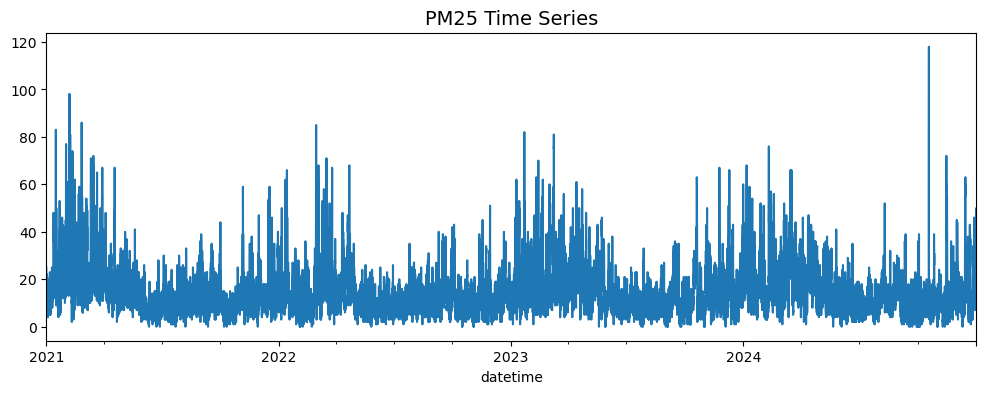

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

path_bb = "./fig/"
colm = "PM25"

# 2) 把 datetime 設成 index（時間序列很常這樣做）
df_plot = df_all.set_index("datetime").sort_index()

# 3) 畫圖
ax = df_plot[colm].plot(figsize=(12, 4))

plt.title(f"{colm} Time Series", fontsize=14)
plt.savefig(f"{path_bb}{colm}_timeseries.png", dpi=300, bbox_inches="tight")
plt.show()


In [30]:
df_all

,datetime,PM25,TEMP,RH,wind_speed,wind_direc,rainfall,WD,WD_sin,WD_cos,hour,weekday,month,season
0,2021-01-01 00:00:00,25.0,10.3,71.0,0.4,334.0,0.0,334.0,-0.438371,0.898794,0,4,1,1
1,2021-01-01 01:00:00,24.0,10.5,70.0,0.5,349.0,0.0,349.0,-0.190809,0.981627,1,4,1,1
2,2021-01-01 02:00:00,20.0,10.4,70.0,0.4,355.0,0.0,355.0,-0.087156,0.996195,2,4,1,1
3,2021-01-01 03:00:00,19.0,10.4,70.0,0.5,23.0,0.0,23.0,0.390731,0.920505,3,4,1,1
4,2021-01-01 04:00:00,13.0,10.6,70.0,0.5,25.0,0.0,25.0,0.422618,0.906308,4,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2024-12-31 19:00:00,37.0,15.4,55.0,1.1,329.0,0.0,329.0,-0.515038,0.857167,19,1,12,1
35060,2024-12-31 20:00:00,42.0,15.1,56.0,1.0,312.0,0.0,312.0,-0.743145,0.669131,20,1,12,1
35061,2024-12-31 21:00:00,46.0,15.0,59.0,1.5,18.0,0.0,18.0,0.309017,0.951057,21,1,12,1
35062,2024-12-31 22:00:00,50.0,14.8,62.0,1.5,39.0,0.0,39.0,0.629320,0.777146,22,1,12,1


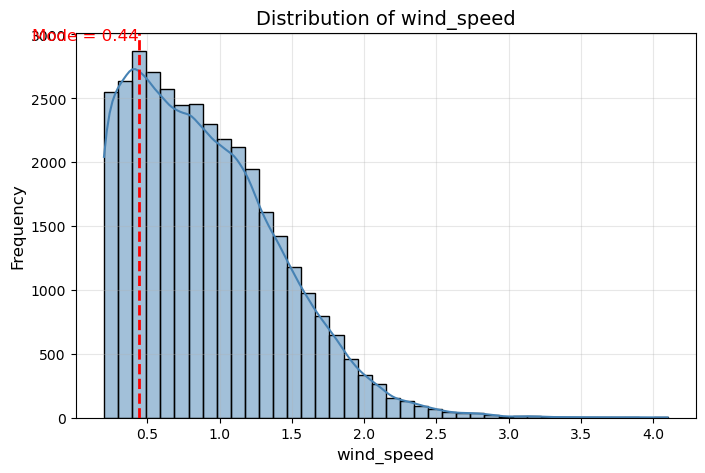

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 要畫的欄位名稱
col = "wind_speed"

plt.figure(figsize=(8,5))

# Histogram + KDE（KDE 就是藍色那條）
sns.histplot(df_all[col], bins=40, kde=True, color="steelblue")

# 計算眾數（mode）
counts, bin_edges = np.histogram(df_all[col].dropna(), bins=40)
mode_index = np.argmax(counts)
mode_value = (bin_edges[mode_index] + bin_edges[mode_index+1]) / 2

# 畫紅色的 Mode 虛線
plt.axvline(mode_value, color="red", linestyle="--", linewidth=2)

# 標註文字
plt.text(
    mode_value,
    max(counts) * 1.02,
    f"Mode = {mode_value:.2f}",
    color="red",
    ha="right",
    va="bottom",
    fontsize=12
)

# 加上坐標軸標題
plt.xlabel(col, fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# 主標題
plt.title(f"Distribution of {col}", fontsize=14)

plt.grid(alpha=0.3)

plt.savefig(f"{path_bb}{col}_distribution.png", dpi=300)
plt.show()


# 風向

<Figure size 600x600 with 0 Axes>

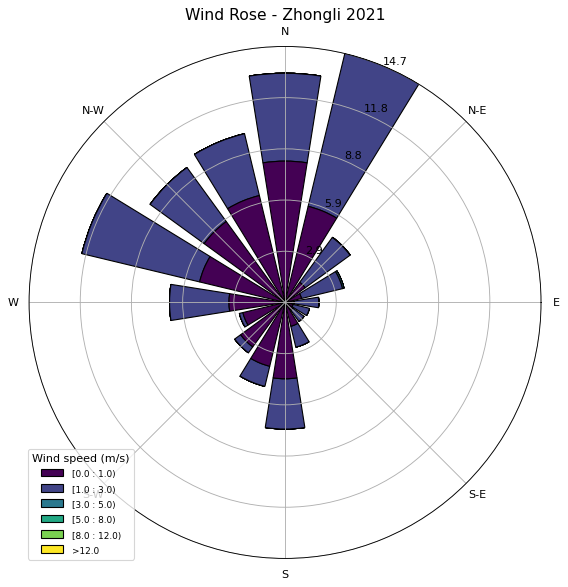

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from windrose import WindroseAxes

# 先把有缺值的丟掉
#ws = df_all["wind_speed"]
#wd = df_all["wind_direc"]

year = 2021

mask_year = df_all["datetime"].dt.year == year
df_y = df_all[mask_year]

ws = df_y["wind_speed"]
wd = df_y["wind_direc"]
mask = ws.notna() & wd.notna()
ws = ws[mask]
wd = wd[mask]

# 風玫瑰圖
plt.figure(figsize=(6, 6))
ax = WindroseAxes.from_ax()

# bins 可以改成你想要的風速級距
speed_bins = [0, 1, 3, 5, 8, 12]   # m/s
ax.bar(
    wd, ws,
    bins=speed_bins,
    normed=True,
    opening=0.8,
    edgecolor="black"
)

ax.set_legend(title="Wind speed (m/s)")
ax.set_title(f"Wind Rose - Zhongli {year}", fontsize=14)

plt.savefig(f"{path_bb}wind_rose{year}.png", dpi=300, bbox_inches="tight")
plt.show()


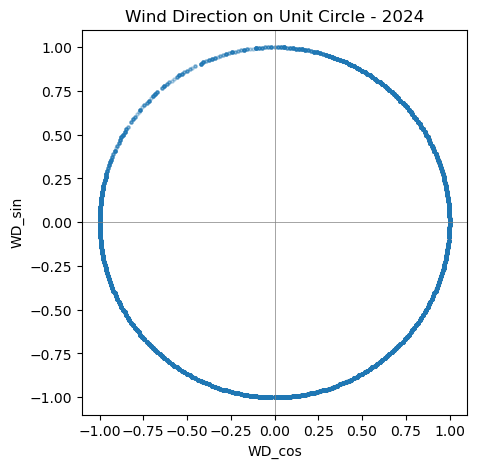

In [48]:
import matplotlib.pyplot as plt

year = 2024  # 你要的年份

df_y = df_all[df_all["datetime"].dt.year == year]

mask = df_y["WD_sin"].notna() & df_y["WD_cos"].notna()
x = df_y.loc[mask, "WD_cos"]
y = df_y.loc[mask, "WD_sin"]

plt.figure(figsize=(5, 5))
plt.scatter(x, y, s=5, alpha=0.3)

plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)

plt.xlabel("WD_cos")
plt.ylabel("WD_sin")
plt.title(f"Wind Direction on Unit Circle - {year}")

plt.gca().set_aspect("equal", "box")

plt.savefig(f"{path_bb}wind_direction_unit_circle_{year}.png", dpi=300, bbox_inches="tight")
plt.show()
